# 09d: Temporal Analysis

**Key Question:** Does the path structure reflect the 4-play trick periodicity?

**Analyses:**
1. **Autocorrelation**: Does V(t) predict V(t+k) better than depth alone?
2. **Change Point Detection**: Discrete "regime changes" along paths?
3. **Periodicity**: 4-depth pattern in Fourier spectrum?

In [1]:
# === CONFIGURATION ===
DATA_DIR = "/mnt/d/shards-standard/"
PROJECT_ROOT = "/home/jason/v2/mk5-tailwind"

# === Setup imports ===
import sys
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
from tqdm.notebook import tqdm
import random
import gc

from forge.analysis.utils import loading, features, viz, navigation
from forge.oracle import schema, tables

try:
    import ruptures as rpt
    HAS_RUPTURES = True
except ImportError:
    HAS_RUPTURES = False
    print("WARNING: ruptures not installed, skipping change point analysis")

viz.setup_notebook_style()
print("Ready")

Ready


In [2]:
# Find available shard files - prefer val/test for faster sampling
val_files = loading.find_shard_files(DATA_DIR + "val/")
test_files = loading.find_shard_files(DATA_DIR + "test/")
train_files = loading.find_shard_files(DATA_DIR + "train/")

all_files = val_files + test_files
random.shuffle(all_files)
random.shuffle(train_files)
shard_files = all_files + train_files

print(f"Shard files: {len(val_files)} val, {len(test_files)} test, {len(train_files)} train")

N_SHARDS = 30
MAX_ROWS = 20_000_000
N_PATHS_TARGET = 100  # Target number of V-trajectories to trace
print(f"Using up to {N_SHARDS} shards, target {N_PATHS_TARGET} paths")

Shard files: 95 val, 95 test, 1124 train
Using up to 30 shards, target 100 paths


## Data Collection: Trace V-Trajectories Along Principal Variation

In [3]:
def trace_v_trajectory(start_state, seed, decl_id, state_to_idx, V, Q):
    """Trace V values along principal variation from start_state."""
    pv = navigation.trace_principal_variation(start_state, seed, decl_id, state_to_idx, V, Q)
    if len(pv) < 5:
        return None
    
    # Extract V trajectory and depths
    v_values = []
    depths = []
    for state, v, action in pv:
        v_values.append(v)
        depths.append(features.depth(np.array([state]))[0])
    
    return {
        'V': np.array(v_values),
        'depths': np.array(depths),
        'length': len(v_values),
        'seed': seed,
        'decl_id': decl_id
    }


# Collect V-trajectories
all_paths = []
skipped = 0
processed = 0

for shard_file in tqdm(shard_files[:N_SHARDS], desc="Processing shards"):
    if len(all_paths) >= N_PATHS_TARGET:
        break
    
    df, seed, decl_id = schema.load_file(shard_file)
    
    if len(df) > MAX_ROWS:
        skipped += 1
        del df
        gc.collect()
        continue
    
    processed += 1
    
    # Build index
    states = df['state'].values
    V = df['V'].values
    
    # Extract Q values
    q_cols = [c for c in df.columns if c.startswith('q')]
    Q = df[q_cols].values if q_cols else None
    
    state_to_idx = {s: i for i, s in enumerate(states)}
    
    # Sample random starting states (not too deep, not too shallow)
    depths_arr = features.depth(states)
    mid_depth_mask = (depths_arr >= 20) & (depths_arr <= 26)
    mid_depth_idx = np.where(mid_depth_mask)[0]
    
    if len(mid_depth_idx) > 0 and Q is not None:
        n_sample = min(5, len(mid_depth_idx))
        sample_idx = np.random.choice(mid_depth_idx, n_sample, replace=False)
        
        for idx in sample_idx:
            start_state = states[idx]
            path = trace_v_trajectory(start_state, seed, decl_id, state_to_idx, V, Q)
            if path is not None:
                all_paths.append(path)
    
    del df, states, V, Q, state_to_idx, depths_arr
    gc.collect()

print(f"\nProcessed {processed} shards, skipped {skipped}")
print(f"Collected {len(all_paths)} V-trajectories")

Processing shards:   0%|          | 0/30 [00:00<?, ?it/s]


Processed 15 shards, skipped 15
Collected 74 V-trajectories


In [4]:
# Path length distribution
lengths = [p['length'] for p in all_paths]
print(f"Path length: mean={np.mean(lengths):.1f}, min={np.min(lengths)}, max={np.max(lengths)}")

Path length: mean=20.9, min=7, max=24


## Analysis 1: Autocorrelation of V-Trajectories

In [5]:
def compute_autocorr(V_trajectory, max_lag=10):
    """Compute autocorrelation at each lag."""
    n = len(V_trajectory)
    if n <= max_lag + 1:
        return [np.nan] * max_lag
    
    results = []
    for lag in range(1, max_lag + 1):
        if n - lag < 3:
            results.append(np.nan)
            continue
        x = V_trajectory[:-lag]
        y = V_trajectory[lag:]
        if np.std(x) < 0.01 or np.std(y) < 0.01:
            results.append(np.nan)
        else:
            results.append(np.corrcoef(x, y)[0, 1])
    return results


# Compute autocorrelation for all paths
max_lag = 12
all_autocorrs = []

for path in all_paths:
    ac = compute_autocorr(path['V'], max_lag=max_lag)
    all_autocorrs.append(ac)

autocorr_df = pd.DataFrame(all_autocorrs, columns=[f'lag_{i}' for i in range(1, max_lag + 1)])

# Mean autocorrelation by lag
mean_autocorr = autocorr_df.mean()
std_autocorr = autocorr_df.std()

print("Mean Autocorrelation by Lag:")
for i in range(1, max_lag + 1):
    print(f"  Lag {i:2d}: {mean_autocorr[f'lag_{i}']:.3f} ± {std_autocorr[f'lag_{i}']:.3f}")

Mean Autocorrelation by Lag:
  Lag  1: 0.737 ± 0.319
  Lag  2: 0.649 ± 0.284
  Lag  3: 0.526 ± 0.364
  Lag  4: 0.468 ± 0.392
  Lag  5: 0.350 ± 0.459
  Lag  6: 0.293 ± 0.471
  Lag  7: 0.269 ± 0.489
  Lag  8: 0.264 ± 0.574
  Lag  9: 0.240 ± 0.548
  Lag 10: 0.161 ± 0.550
  Lag 11: 0.183 ± 0.550
  Lag 12: 0.158 ± 0.674


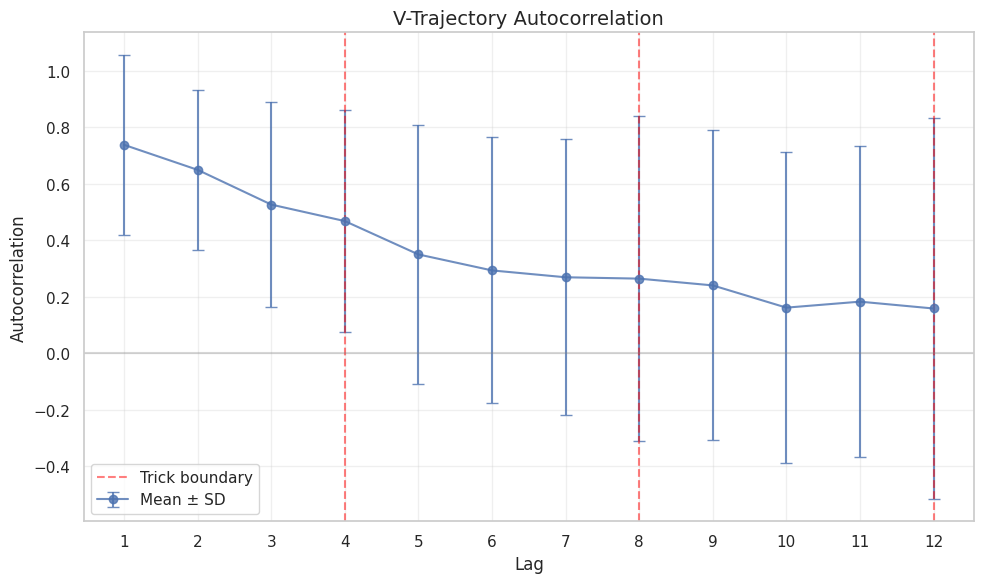

In [6]:
# Plot autocorrelation
fig, ax = plt.subplots(figsize=(10, 6))

lags = range(1, max_lag + 1)
ax.errorbar(lags, mean_autocorr.values, yerr=std_autocorr.values, 
            fmt='b-o', capsize=4, alpha=0.8, label='Mean ± SD')

# Mark trick boundaries (every 4 moves)
for trick_lag in [4, 8, 12]:
    if trick_lag <= max_lag:
        ax.axvline(x=trick_lag, color='red', linestyle='--', alpha=0.5, 
                   label='Trick boundary' if trick_lag == 4 else None)

ax.axhline(y=0, color='gray', linestyle='-', alpha=0.3)
ax.set_xlabel('Lag', fontsize=12)
ax.set_ylabel('Autocorrelation', fontsize=12)
ax.set_title('V-Trajectory Autocorrelation', fontsize=14)
ax.set_xticks(lags)
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../../results/figures/09d_autocorrelation.png', dpi=150, bbox_inches='tight')
plt.show()

## Analysis 2: Change Point Detection

In [7]:
if HAS_RUPTURES and len(all_paths) > 0:
    # PELT algorithm for change point detection
    def detect_changepoints(V_trajectory, pen=5):
        """Detect change points in V trajectory."""
        if len(V_trajectory) < 5:
            return []
        
        try:
            signal = V_trajectory.reshape(-1, 1).astype(float)
            algo = rpt.Pelt(model="l2", min_size=2).fit(signal)
            result = algo.predict(pen=pen)
            # Remove the final point (always returned by ruptures)
            if len(result) > 0 and result[-1] == len(V_trajectory):
                result = result[:-1]
            return result
        except Exception as e:
            return []
    
    # Collect all change points
    all_changepoints = []
    changepoints_relative = []  # Position as fraction of path
    
    for path in all_paths:
        cps = detect_changepoints(path['V'])
        for cp in cps:
            all_changepoints.append(cp)
            changepoints_relative.append(cp / path['length'])
    
    print(f"Total change points detected: {len(all_changepoints)}")
    if len(all_changepoints) > 0:
        print(f"Mean per path: {len(all_changepoints) / len(all_paths):.1f}")
        print(f"Mean position: {np.mean(all_changepoints):.1f}")
else:
    all_changepoints = []
    changepoints_relative = []
    print("Skipping change point analysis (ruptures not available or no paths)")

Total change points detected: 212
Mean per path: 2.9
Mean position: 11.2


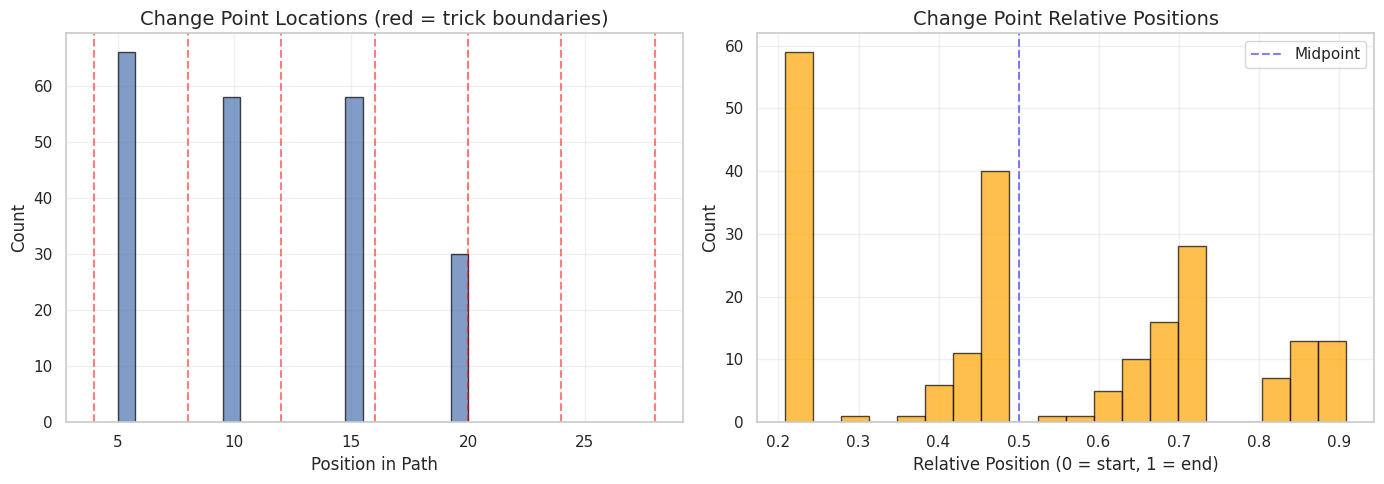

In [8]:
if len(all_changepoints) > 0:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # Absolute positions
    ax1.hist(all_changepoints, bins=20, alpha=0.7, edgecolor='black')
    # Mark trick boundaries (every 4)
    for trick in range(4, 29, 4):
        ax1.axvline(x=trick, color='red', linestyle='--', alpha=0.5)
    ax1.set_xlabel('Position in Path', fontsize=12)
    ax1.set_ylabel('Count', fontsize=12)
    ax1.set_title('Change Point Locations (red = trick boundaries)', fontsize=14)
    ax1.grid(True, alpha=0.3)
    
    # Relative positions
    ax2.hist(changepoints_relative, bins=20, alpha=0.7, edgecolor='black', color='orange')
    ax2.axvline(x=0.5, color='blue', linestyle='--', alpha=0.5, label='Midpoint')
    ax2.set_xlabel('Relative Position (0 = start, 1 = end)', fontsize=12)
    ax2.set_ylabel('Count', fontsize=12)
    ax2.set_title('Change Point Relative Positions', fontsize=14)
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('../../results/figures/09d_changepoints.png', dpi=150, bbox_inches='tight')
    plt.show()
else:
    print("No change points to plot")

## Analysis 3: Periodicity (Fourier Analysis)

In [9]:
from scipy.fft import fft, fftfreq

def analyze_periodicity(V_trajectory):
    """Compute Fourier spectrum of V trajectory."""
    n = len(V_trajectory)
    if n < 8:
        return None, None
    
    # Use ΔV (changes) rather than absolute V
    delta_V = np.diff(V_trajectory)
    
    # Zero-pad to power of 2 for FFT efficiency
    n_fft = 2 ** int(np.ceil(np.log2(len(delta_V))))
    padded = np.zeros(n_fft)
    padded[:len(delta_V)] = delta_V
    
    spectrum = np.abs(fft(padded))
    freqs = fftfreq(n_fft)
    
    # Only positive frequencies
    pos_mask = freqs > 0
    return freqs[pos_mask], spectrum[pos_mask]


# Compute spectra for all paths
all_spectra = []

for path in all_paths:
    freqs, spectrum = analyze_periodicity(path['V'])
    if freqs is not None:
        all_spectra.append({'freqs': freqs, 'spectrum': spectrum})

print(f"Computed {len(all_spectra)} spectra")

Computed 73 spectra


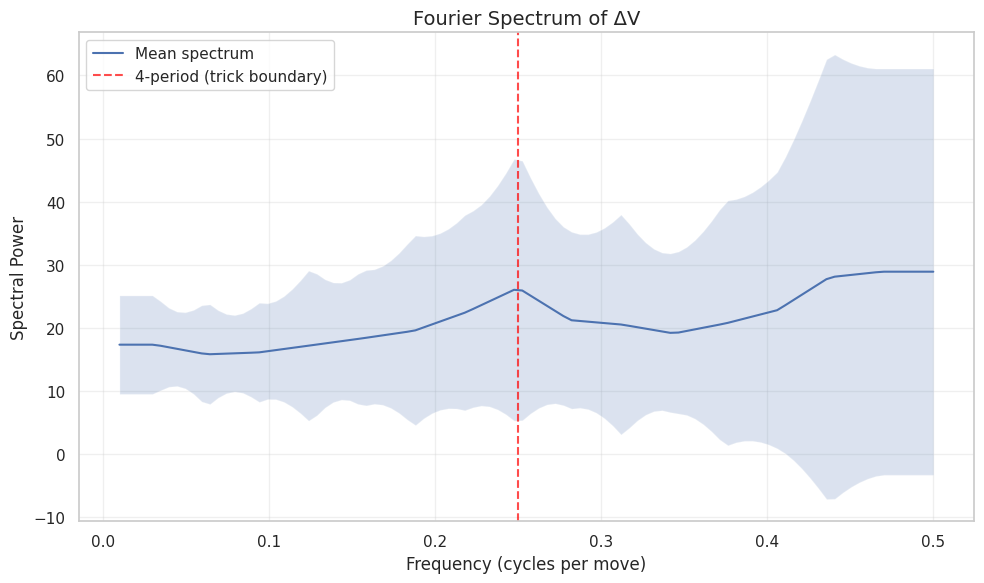


Power at 4-period frequency: 26.03
Fraction of total power: 1.2%


In [10]:
# Average spectrum (interpolated to common frequency grid)
if len(all_spectra) > 0:
    # Use a common frequency grid
    common_freqs = np.linspace(0.01, 0.5, 100)
    interpolated_spectra = []
    
    for s in all_spectra:
        # Interpolate to common grid
        interp_spec = np.interp(common_freqs, s['freqs'], s['spectrum'])
        interpolated_spectra.append(interp_spec)
    
    mean_spectrum = np.mean(interpolated_spectra, axis=0)
    std_spectrum = np.std(interpolated_spectra, axis=0)
    
    # Plot
    fig, ax = plt.subplots(figsize=(10, 6))
    
    ax.plot(common_freqs, mean_spectrum, 'b-', label='Mean spectrum')
    ax.fill_between(common_freqs, mean_spectrum - std_spectrum, mean_spectrum + std_spectrum, 
                    alpha=0.2)
    
    # Mark the 4-period (trick boundary) frequency = 0.25 cycles per move
    ax.axvline(x=0.25, color='red', linestyle='--', alpha=0.7, label='4-period (trick boundary)')
    
    ax.set_xlabel('Frequency (cycles per move)', fontsize=12)
    ax.set_ylabel('Spectral Power', fontsize=12)
    ax.set_title('Fourier Spectrum of ΔV', fontsize=14)
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('../../results/figures/09d_periodicity.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    # Power at trick-boundary frequency
    idx_025 = np.argmin(np.abs(common_freqs - 0.25))
    power_at_trick = mean_spectrum[idx_025]
    total_power = np.sum(mean_spectrum)
    frac_trick = power_at_trick / total_power * 100
    
    print(f"\nPower at 4-period frequency: {power_at_trick:.2f}")
    print(f"Fraction of total power: {frac_trick:.1f}%")
else:
    print("No spectra to analyze")

## Analysis 4: V ~ Depth vs V ~ Lagged V

In [11]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Aggregate all (V, depth, lagged_V) tuples
all_data = []

for path in all_paths:
    V = path['V']
    depths = path['depths']
    for i in range(1, len(V)):
        all_data.append({
            'V': V[i],
            'depth': depths[i],
            'V_lag1': V[i-1],
            'V_lag4': V[i-4] if i >= 4 else np.nan
        })

data_df = pd.DataFrame(all_data).dropna()
print(f"Data points: {len(data_df)}")

# Model 1: V ~ depth
X_depth = data_df[['depth']].values
y = data_df['V'].values

model_depth = LinearRegression().fit(X_depth, y)
r2_depth = r2_score(y, model_depth.predict(X_depth))

# Model 2: V ~ V_lag1
X_lag1 = data_df[['V_lag1']].values
model_lag1 = LinearRegression().fit(X_lag1, y)
r2_lag1 = r2_score(y, model_lag1.predict(X_lag1))

# Model 3: V ~ V_lag4 (one trick ago)
X_lag4 = data_df[['V_lag4']].values
model_lag4 = LinearRegression().fit(X_lag4, y)
r2_lag4 = r2_score(y, model_lag4.predict(X_lag4))

# Model 4: V ~ depth + V_lag1
X_both = data_df[['depth', 'V_lag1']].values
model_both = LinearRegression().fit(X_both, y)
r2_both = r2_score(y, model_both.predict(X_both))

print(f"\nR² Comparison:")
print(f"  V ~ depth:           {r2_depth:.4f}")
print(f"  V ~ V_lag1:          {r2_lag1:.4f}")
print(f"  V ~ V_lag4:          {r2_lag4:.4f}")
print(f"  V ~ depth + V_lag1:  {r2_both:.4f}")

Data points: 1253

R² Comparison:
  V ~ depth:           0.0052
  V ~ V_lag1:          0.8013
  V ~ V_lag4:          0.7264
  V ~ depth + V_lag1:  0.8015


## Summary Statistics

In [12]:
# Compute summary statistics
summary_data = {
    'metric': [
        'Total paths analyzed',
        'Mean path length',
        'Autocorr at lag 1',
        'Autocorr at lag 4',
        'Change points per path',
        'R² (V ~ depth)',
        'R² (V ~ V_lag1)',
        'R² (V ~ depth + lag1)',
    ],
    'value': [
        len(all_paths),
        f"{np.mean(lengths):.1f}",
        f"{mean_autocorr['lag_1']:.3f}" if not np.isnan(mean_autocorr['lag_1']) else "N/A",
        f"{mean_autocorr['lag_4']:.3f}" if not np.isnan(mean_autocorr['lag_4']) else "N/A",
        f"{len(all_changepoints) / len(all_paths):.1f}" if len(all_paths) > 0 else "N/A",
        f"{r2_depth:.4f}",
        f"{r2_lag1:.4f}",
        f"{r2_both:.4f}",
    ]
}

summary_df = pd.DataFrame(summary_data)
print(summary_df.to_string(index=False))

summary_df.to_csv('../../results/tables/09d_temporal.csv', index=False)
print("\nSaved to results/tables/09d_temporal.csv")

                metric  value
  Total paths analyzed     74
      Mean path length   20.9
     Autocorr at lag 1  0.737
     Autocorr at lag 4  0.468
Change points per path    2.9
        R² (V ~ depth) 0.0052
       R² (V ~ V_lag1) 0.8013
 R² (V ~ depth + lag1) 0.8015

Saved to results/tables/09d_temporal.csv


## Conclusion

In [13]:
print("=" * 60)
print("TEMPORAL ANALYSIS CONCLUSIONS")
print("=" * 60)

# Autocorrelation
print(f"\n1. AUTOCORRELATION")
lag1_ac = mean_autocorr['lag_1']
lag4_ac = mean_autocorr['lag_4']
if not np.isnan(lag1_ac):
    print(f"   Lag-1: {lag1_ac:.3f}")
    if lag1_ac > 0.8:
        print(f"   STRONG: V is highly predictable from previous move")
    elif lag1_ac > 0.5:
        print(f"   MODERATE: Significant path memory")
    else:
        print(f"   WEAK: Limited temporal dependence")

# Trick periodicity
print(f"\n2. TRICK PERIODICITY")
if not np.isnan(lag4_ac):
    print(f"   Lag-4 autocorrelation: {lag4_ac:.3f}")
    if lag4_ac > lag1_ac * 0.5:
        print(f"   VISIBLE: 4-move (trick) structure in temporal dependence")
    else:
        print(f"   WEAK: No strong 4-move periodicity")

# Predictive models
print(f"\n3. PREDICTIVE MODELS")
print(f"   R²(depth): {r2_depth:.3f}")
print(f"   R²(lag1):  {r2_lag1:.3f}")
print(f"   R²(both):  {r2_both:.3f}")
improvement = r2_both - r2_depth
if improvement > 0.1:
    print(f"   PATH HISTORY MATTERS: +{improvement:.1%} R² from path memory")
else:
    print(f"   DEPTH DOMINATES: Path history adds little beyond depth")

print("\n" + "=" * 60)

TEMPORAL ANALYSIS CONCLUSIONS

1. AUTOCORRELATION
   Lag-1: 0.737
   MODERATE: Significant path memory

2. TRICK PERIODICITY
   Lag-4 autocorrelation: 0.468
   VISIBLE: 4-move (trick) structure in temporal dependence

3. PREDICTIVE MODELS
   R²(depth): 0.005
   R²(lag1):  0.801
   R²(both):  0.801
   PATH HISTORY MATTERS: +79.6% R² from path memory

